# Exploratory Data Analysis of Stimulus Triggered Averages
*Ian Malone*

### Load data and check structure

In [98]:
import pandas as pd

df_sta = pd.read_csv('D:\\Data\\df_STA_2020_12_01.csv')
df_sta.head()

,Animal,Day,Side,Stim_Amplitude,Sample,STA_Amplitude
0,S01,D04,Left,100.0,0,0.065894
1,S01,D04,Left,100.0,1,0.109876
2,S01,D04,Left,100.0,2,0.131164
3,S01,D04,Left,100.0,3,0.101857
4,S01,D04,Left,100.0,4,0.125714


In [99]:
df_sta.dtypes

Animal             object
Day                object
Side               object
Stim_Amplitude    float64
Sample              int64
STA_Amplitude     float64
dtype: object

#### For this analysis, we will only keep the right side EMG

In [100]:
df_sta = df_sta[df_sta["Side"] == 'Right']

In [101]:
# this is here to correct a typo in a file name... 
df_sta.loc[df_sta.Day == 'D13', 'Day'] = 'D14'

In [102]:
print(df_sta.Animal.unique())
print(df_sta.Day.unique())
print(df_sta.Side.unique())
print(df_sta.Stim_Amplitude.unique())

['S01' 'S02' 'S03' 'S04' 'S05' 'S06']
['D04' 'D06' 'D08' 'D10' 'D12' 'D14' 'D16' 'D18']
['Right']
[100. 110. 120. 130. 140. 150. 160. 170. 180. 190. 200. 210. 220. 230.
 240. 250. 260. 270. 280. 290. 300. 310. 320. 330. 340. 350. 360. 370.
 380. 390. 400. 410. 420. 430. 440. 450. 460. 470. 480. 490. 500. 510.
 520. 530. 540. 550. 560. 570. 580. 590. 600.]


#### We will also change the 'Day' column to have integer values.

In [103]:
df_sta['Day'] = df_sta['Day'].str[-2:].astype(int)
df_sta.head(), df_sta.dtypes, 

(     Animal  Day   Side  Stim_Amplitude  Sample  STA_Amplitude
 6150    S01    4  Right           100.0       0       0.119449
 6151    S01    4  Right           100.0       1       0.156867
 6152    S01    4  Right           100.0       2       0.173611
 6153    S01    4  Right           100.0       3       0.184769
 6154    S01    4  Right           100.0       4       0.171930,
 Animal             object
 Day                 int32
 Side               object
 Stim_Amplitude    float64
 Sample              int64
 STA_Amplitude     float64
 dtype: object)

### Plot stimulus triggered average waveforms
##### For each current amplitude, each animal, and each day
There is a lot of data here, so we will subset. Only plot waveforms of stimulation amplitudes divisible by 50 on odd numbered days. We also need to remove the stimulus artifact.

In [104]:
df_sta_50 = df_sta[(df_sta["Stim_Amplitude"] % 50) == 0] # keep only stimulus amplitudes divisible by 50
"Unique stimulation amplitudes after subsetting are %s uA." % (df_sta_50.Stim_Amplitude.unique())

'Unique stimulation amplitudes after subsetting are [100. 150. 200. 250. 300. 350. 400. 450. 500. 550. 600.] uA.'

###### The plot below is the raw STA data before any processing

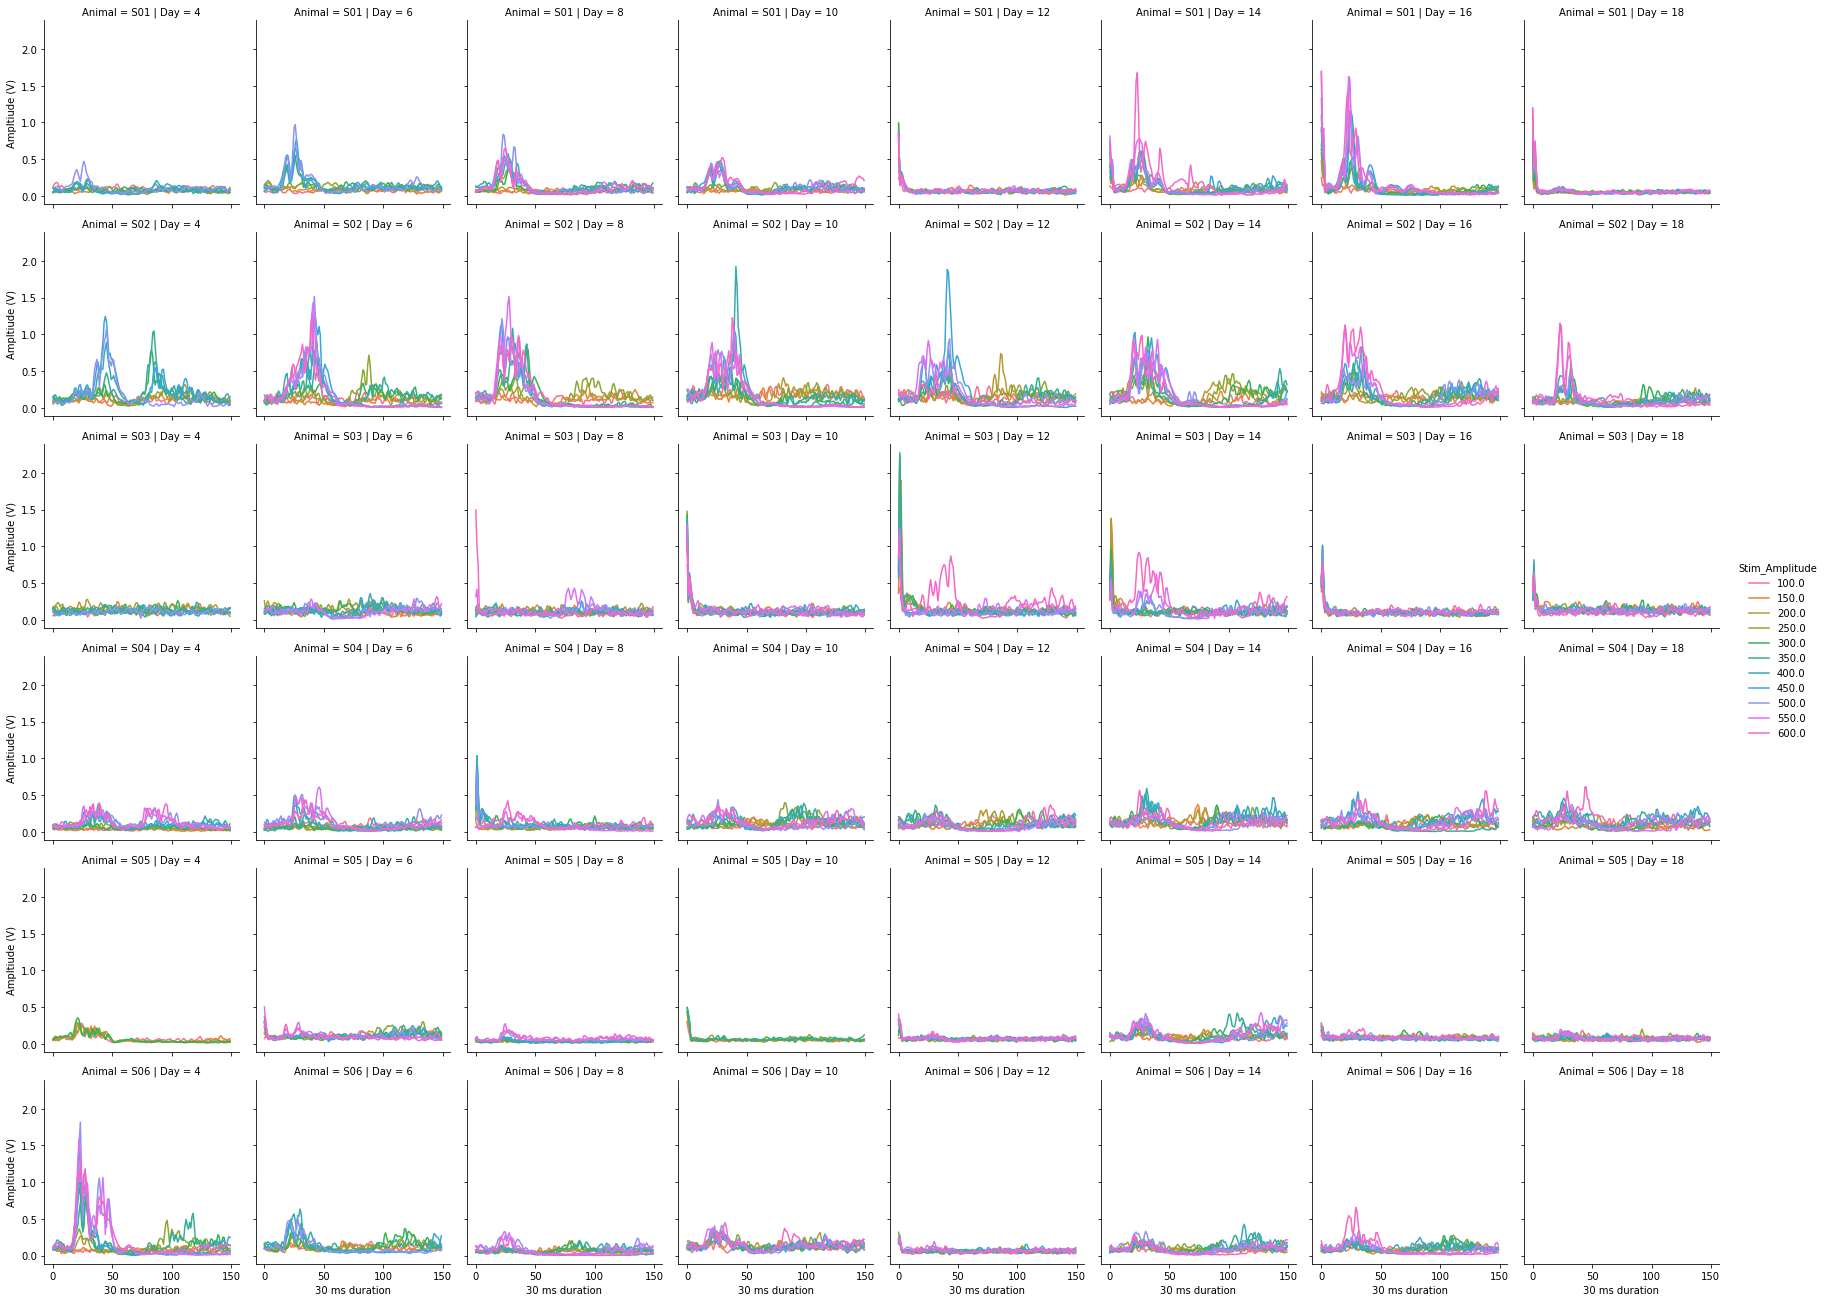

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(df_sta_50, col='Day', row='Animal', hue='Stim_Amplitude')
g.map_dataframe(sns.lineplot, x='Sample', y='STA_Amplitude')
g.set_axis_labels('30 ms duration', 'Ampltiude (V)')
g.add_legend()

###### These traces need to be normalized so they can be compared. This step should be given a lot of thought as normalization schemes can dramatically influence your model. The stimulus artifact must also be removed so it does not affect the normalization.

As a first pass, we will use a min/max scaler. Take all days for each animal and rescale the STAs such that all values are between 0 and 1

In [117]:
# remove the stimulus artifact by deleting samples 0 to 9
df_sta = df_sta[df_sta['Sample'] >= 10]
df_sta_50 = df_sta_50[df_sta_50['Sample'] >= 10]

# scale STA values to be within the range [0,1]
from sklearn.preprocessing import minmax_scale

STA_Scaled = df_sta.groupby(['Animal', 'Side'])['STA_Amplitude'].transform(lambda x: minmax_scale(x.astype(float)))
df_sta_norm = df_sta.copy()
df_sta_norm['STA_Scaled'] = df_sta_norm.index.map(STA_Scaled)
df_sta_norm = df_sta_norm.reset_index(drop=True)

STA_Scaled_50 = df_sta_50.groupby(['Animal', 'Side'])['STA_Amplitude'].transform(lambda x: minmax_scale(x.astype(float)))
df_sta_50_norm = df_sta_50.copy()
df_sta_50_norm['STA_Scaled'] = df_sta_50_norm.index.map(STA_Scaled_50)
df_sta_50_norm = df_sta_50_norm.reset_index(drop=True)

###### The plot below shows the normalized STAs with stimulus artifact removed

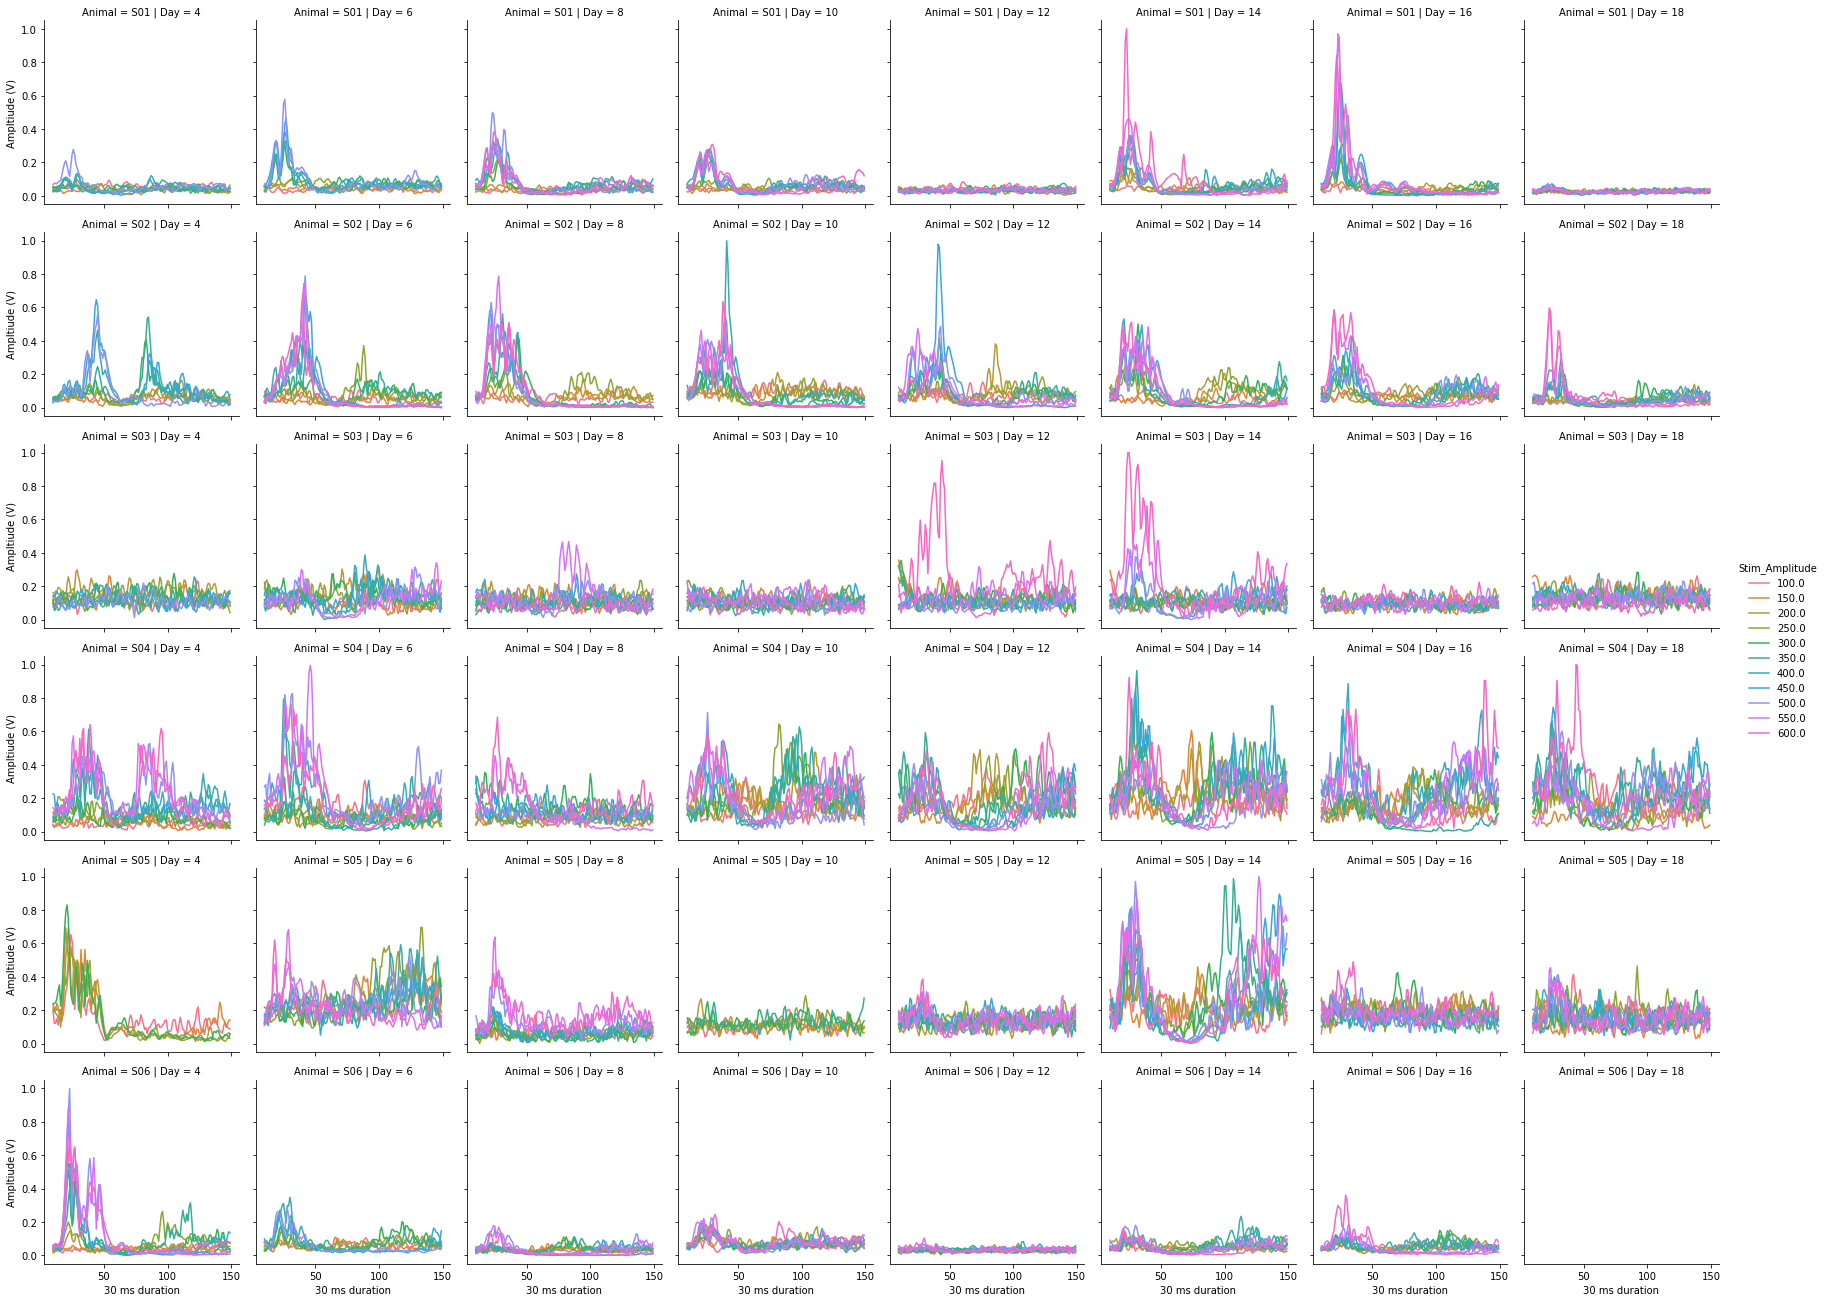

In [121]:
g = sns.FacetGrid(df_sta_50_norm, col='Day', row='Animal', hue='Stim_Amplitude')
g.map_dataframe(sns.lineplot, x='Sample', y='STA_Scaled')
g.set_axis_labels('30 ms duration', 'Ampltiude (V)')
g.add_legend()

### Calculate area under the stimulus triggered average curves 
##### For each current amplitude, each animal, and each day

In [8]:
df_sta_norm.head()

,Animal,Day,Side,Stim_Amplitude,Sample,STA_Amplitude
6150,S01,4,Right,100.0,0,0.119449
6151,S01,4,Right,100.0,1,0.156867
6152,S01,4,Right,100.0,2,0.173611
6153,S01,4,Right,100.0,3,0.184769
6154,S01,4,Right,100.0,4,0.171930


The dataframe looks as expected. We now want to add a column that defines sample bins of interest so we can compare metrics at different latencies (e.g., how does the area under the curve differ in the bins 0 to 5 ms vs. 5 to 10 ms?). We will first convert 'Sample' to 'Time' and then define bins of interest.

In [9]:
sampling_frequency = 5000 # hertz
df_sta['Time'] = df_sta['Sample']/sampling_frequency # create time column based on samples and sampling frequency

bins = [0.001, 0.006, 0.011, 0.016, 0.021, 0.026] # define bins
#labels = ['1 to 6 ms', '6 to 11 ms', '11 to 16 ms', '16 to 21 ms', '21 to 26 ms'] # define bin labels
labels = [1, 2, 3, 4, 5]
df_sta['Time_Bin'] = pd.cut(df_sta['Time'], bins, labels=labels, right=False) # add Time_Bin column to dataframe
df_sta = df_sta.reindex(columns=['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Sample', 'Time', 'Time_Bin', 'STA_Amplitude'])

df_sta.head()

,Animal,Day,Side,Stim_Amplitude,Sample,Time,Time_Bin,STA_Amplitude
6150,S01,4,Right,100.0,0,0.0000,NaN,0.119449
6151,S01,4,Right,100.0,1,0.0002,NaN,0.156867
6152,S01,4,Right,100.0,2,0.0004,NaN,0.173611
6153,S01,4,Right,100.0,3,0.0006,NaN,0.184769
6154,S01,4,Right,100.0,4,0.0008,NaN,0.171930


_Note that the NaN value for the first several rows caused by purposely excluding the first 1 ms of data in order to remove any stimulus artifacts. This can be changed._

We now need to integrate the stimulus triggered average curves to find the area beneath them. We can then compare these areas under the curve (AUCs) between groups, days, stimulus intensities, etc.

The trapezoidal rule provides a simple way to integrate a function but typically has much larger error than Simpson's rule without saving significant compute time. We will use Simpson's rule.

In [10]:
from scipy import integrate

df_auc = df_sta.groupby(['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Time_Bin'])['STA_Amplitude'].apply(integrate.simps).reset_index()
df_auc.rename(columns = {'STA_Amplitude':'STA_AUC'}, inplace = True)
df_auc.head()

,Animal,Day,Side,Stim_Amplitude,Time_Bin,STA_AUC
0,S01,4,Right,100.0,1,2.497616
1,S01,4,Right,100.0,2,2.492178
2,S01,4,Right,100.0,3,2.549094
3,S01,4,Right,100.0,4,2.191393
4,S01,4,Right,100.0,5,2.020577


### Exploratory Data Analysis

We have our final data frame to use for this analysis, df_auc, and we can start our EDA.

<AxesSubplot:xlabel='Day', ylabel='Animal'>

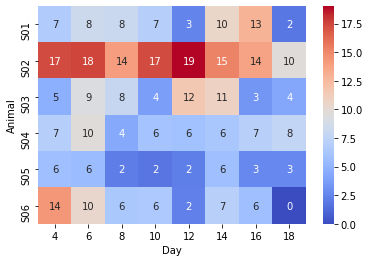

In [13]:
# Use a heatmap to look at animal (y), day (x), and mean AUC (heat)

df_animal_day = df_auc.groupby(['Animal', 'Day'])['STA_AUC'].max().reset_index()
df_animal_day_pivot = df_animal_day.pivot(index='Animal', columns='Day', values='STA_AUC').fillna(0)
sns.heatmap(df_animal_day_pivot, annot=True, fmt='.0f', cmap="coolwarm")

###### This heatmap doesn't look very informative, maybe because nothing has been normalized...

If we are interested in change over time, we need a metric that shows how much the AUC has changed since day 1. There are __many__ different normalization schemes and they can dramatically influence the results of your model.

Before normalizing, we can look at how the data are distributed over time for each animal.

### Other analyses

Peak to peak from stimulus triggered average for each current amplitude, each animal, each day
Latency from stimulus pulse to stimulus triggered average for each current amplitude, each animal, each day
Time domains of stimulus triggered average
Differences in any of these parameters based on time of day?
How are we going to present the impedance data in the Neilsen paper? I’m still not clear on this.
Additional things we can look at (e.g., wavelet, FFT, HMM, etc.)
Look in manuscript file for notes on ideas. Also look in Daily Notes on OneNote for papers that did EMG analysis well.